Test interpolation routines with some sample data.

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import xarray as xr
import numpy as np
import marc_analysis as ma

from ipywidgets import interact

Open a sample dataset, and select a portion of its grid.

In [19]:
test_ds = xr.open_dataset("medium_sample.nc",)
test_ds = test_ds.isel(time=0, lat=slice(-60, 60))

print(test_ds)

/Users/daniel/anaconda/lib/python3.4/site-packages/xarray/conventions.py:382: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/Users/daniel/anaconda/lib/python3.4/site-packages/xarray/conventions.py:401: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  calendar=self.calendar)


<xarray.Dataset>
Dimensions:              (cosp_prs: 7, cosp_tau_modis: 6, ilev: 31, lat: 24, lev: 30, lon: 144, nbnd: 2, slat: 95, slon: 144)
Coordinates:
  * lev                  (lev) float64 3.643 7.595 14.36 24.61 38.27 54.6 ...
  * ilev                 (ilev) float64 2.255 5.032 10.16 18.56 30.67 45.87 ...
  * cosp_prs             (cosp_prs) float64 900.0 740.0 620.0 500.0 375.0 ...
  * cosp_tau_modis       (cosp_tau_modis) float64 0.8 2.45 6.5 16.2 41.5 ...
    time                 object    2-06-15 00:00:00
  * lat                  (lat) float64 -21.79 -19.89 -18.0 -16.11 -14.21 ...
  * lon                  (lon) float64 0.0 2.5 5.0 7.5 10.0 12.5 15.0 17.5 ...
  * slat                 (slat) float64 -89.05 -87.16 -85.26 -83.37 -81.47 ...
  * slon                 (slon) float64 -1.25 1.25 3.75 6.25 8.75 11.25 ...
  * nbnd                 (nbnd) int64 0 1
Data variables:
    hyam                 (lev) float64 0.003643 0.007595 0.01436 0.02461 ...
    hybm                 (lev) fl

## Pressure-level Interpolation

Select the 3D temperature field, and interpolate to specific pressure levels given the background hybrid pressure levels.

In [73]:
field = 'T'
test_data = test_ds[field]

# Compute the 3D pressure field given the hybrid coordinate system
pres_levs = ma.hybrid_to_pressure(test_ds)

# Select pressure levels for interpolation
new_pres_levs = 100.*np.array([300., 500., 750., 850., 960.])
# new_pres_levs = 100.*np.array(np.logspace(2, 3, 50))[-5:]

# Compute interpolated data
new_data_np = ma.interp_to_pres_levels(test_data, pres_levs, new_pres_levs,
                                      'numpy')
# new_data_sp = ma.interp_to_pres_levels(test_data, pres_levs, new_pres_levs,
#                                       'scipy')

# As a safety check, copy attributes into interpolated data
nd = ma.copy_attrs(test_data, new_data_np)
new_data_np.lev.attrs

OrderedDict([('long_name', 'hybrid level at midpoints (1000*(A+B))'),
             ('units', 'level'),
             ('positive', 'down'),
             ('standard_name', 'atmosphere_hybrid_sigma_pressure_coordinate'),
             ('formula_terms', 'a: hyam b: hybm p0: P0 ps: PS')])

Select a column to compare, and plot the original and interpolated data

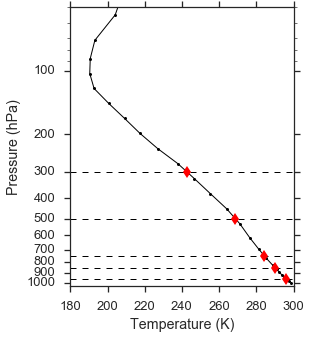

In [76]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import LogFormatter, LogLocator
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
import seaborn as sns
sns.set(style='ticks', context='talk')

@interact(ilat=[0, len(test_ds.lat)-1], ilon=[0, len(test_ds.lon)-1])
def plot_column(ilat, ilon):
    
    interp_np_column = new_data_np.isel(lat=ilat, lon=ilon)
    orig_column = test_data.isel(lat=ilat, lon=ilon)
    pres_column = pres_levs.isel(lat=ilat, lon=ilon)

    fig = plt.figure(figsize=(4, 5))
    ax = fig.add_subplot(111)

    ax.plot(orig_column, pres_column/100., color='k', 
            ms=3, marker='o', lw=1)
    ax.plot(interp_np_column, new_pres_levs/100.,
            linestyle='none', marker='d', color='r')
        
    ax.semilogy()
    ax.set_ylim(1035, 50)
    for p in new_pres_levs/100.:
        ax.hlines(p, *ax.get_xlim(), linestyle='dashed', lw=1)
    
    
    ax.set_xlabel("{} ({})".format(test_data.long_name, 
                                   test_data.units))
    ax.yaxis.set_major_formatter(
        FormatStrFormatter("%d")
    )
    ax.yaxis.set_major_locator(MaxNLocator(10))
    ax.set_ylabel("Pressure (hPa)")
    

## Altitude Interpolation

We now generalize the interpolation to an arbitrary auxiliary coordinate - in this case, the geopotential height field. 

In [112]:
field = 'Q'
test_data = test_ds[field]

heights = test_ds.Z3*1e-3
new_height_levs = np.arange(1, 10.)
print(new_height_levs)

# Compute interpolated data
new_data_np = ma.interp_by_field(test_data, heights, new_height_levs)

# As a safety check, copy attributes into interpolated data
nd = ma.copy_attrs(test_data, new_data_np)
new_data_np.attrs.update(dict(
    long_name='altitude', units='km', positive='up',
    standard_name='altitude'
))

[ 1.  2.  3.  4.  5.  6.  7.  8.  9.]


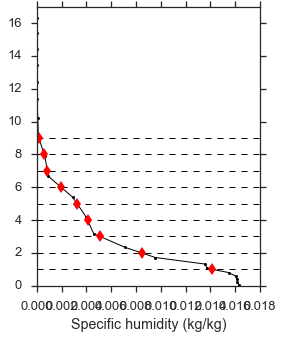

In [113]:
@interact(ilat=[0, len(test_ds.lat)-1], ilon=[0, len(test_ds.lon)-1])
def plot_column(ilat, ilon):
    
    interp_np_column = new_data_np.isel(lat=ilat, lon=ilon)
    orig_column = test_data.isel(lat=ilat, lon=ilon)
    heights_column = heights.isel(lat=ilat, lon=ilon)

    fig = plt.figure(figsize=(4, 5))
    ax = fig.add_subplot(111)

    ax.plot(orig_column, heights_column, color='k', 
            ms=3, marker='o', lw=1)
    ax.plot(interp_np_column, new_height_levs,
            linestyle='none', marker='d', color='r')

    for p in new_height_levs:
        ax.hlines(p, *ax.get_xlim(), linestyle='dashed', lw=1)
    
    ax.set_ylim(0, 17)
    ax.set_xlabel("{} ({})".format(test_data.long_name, 
                                   test_data.units))
    ax.yaxis.set_major_formatter(
        FormatStrFormatter("%d")
    )
#     ax.set_ylabel("{} ({})".format(new_data_np.lev.long_name, 
#                                    new_data_np.lev.units))
    